# 3차과제_와인데이터분류: Using SVM

## **1. 패키지 Import**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **2. 데이터 불러오기**

In [4]:
# Load the dataset
wine_data = pd.read_csv('wine.csv', delimiter=';')

# Inspect the dataset
print(wine_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

## **3. 학습/검증 데이터 분리 및 특징 선택**

In [5]:
from sklearn.model_selection._split import train_test_split

In [6]:
# Select specific features and target
features = ['alcohol', 'volatile acidity']
X = wine_data[features]
wine_data['quality_binary'] = (wine_data['quality'] >= 6).astype(int)
y = wine_data['quality_binary']

In [7]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 2) (320, 2) (1279,) (320,)


## **4. 스케일링**

> **스케일링을 하는 이유?**   
> * 특징 마다 단위가 상이함.   
> * 스케일링은 각 특징의 단위를 ```표준화``` 또는 ```정규화``` 함.

### **표준화: StandardScaler**

* 데이터의 특징을 각각 ```평균이 0```이고, ```분산이 1```인 ```가우시안 정규 분포```를 가진 값으로 변환

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
ss_scaler = StandardScaler()
X_train_ss = ss_scaler.fit_transform(X_train)
X_test_ss = ss_scaler.fit_transform(X_test)

## **5. SVM 모델 객체 생성**

* 데이터 선택: X_train/X_test, X_train_ss/X_test_ss

In [10]:
X_train = X_train_ss
X_test = X_test_ss

In [11]:
from sklearn.svm import SVC

In [12]:
model = SVC()
model.fit(X_train, y_train)

SVC()

* **모델의 하이퍼 파라미터 불러오기**

In [13]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

* **하이퍼 파라미터 튜닝**

In [14]:
model = SVC(
    C = 1,          # 0.1, 1, 10, 100 등
    gamma = 10,      # 0.1, 1, 10, 100 등
    kernel = 'rbf',   # 'linear', 'poly', 'rbf' 등
    # degree = 3,       # 2 ~ 5 등
)

In [15]:
model.fit(X_train, y_train)

SVC(C=1, gamma=10)

* **GridSearch를 통한 하이퍼파라미터 튜닝**

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = {
    "C": [0.1, 1, 10, 100],           # 줄임
    "gamma": [0.1, 1, 10, 100],       # 줄임
    "kernel": ['rbf'],       # 하나의 커널만 선택
}

grid_model = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=2,   # K-fold
    refit=True)

In [18]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(C=1, gamma=10),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['rbf']})

In [19]:
# GridSearch 결과 중, 최적 하이퍼파라미터 학습 모델 객체 반환
print(grid_model.best_params_)
best_model = grid_model.best_estimator_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


## **6. 모델 평가하기**

* 모델 선택:  best_model

In [20]:
model = best_model

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
y_pred = model.predict(X_test)
print(f'분류 정확도: {accuracy_score(y_test, y_pred)}')

분류 정확도: 0.746875


In [23]:
from sklearn.metrics import classification_report

In [24]:
# Unique quality levels for target names
quality_labels = sorted(y_test.unique())  # Ensure labels are sorted

# Generate classification report with appropriate target names
print(classification_report(y_test, y_pred, target_names=[f'Quality {label}' for label in quality_labels]))


              precision    recall  f1-score   support

   Quality 0       0.70      0.75      0.72       141
   Quality 1       0.79      0.74      0.77       179

    accuracy                           0.75       320
   macro avg       0.74      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



## **7. 시각화**

> **주의**
> * 2차원으로 시각화 하기 때문에 특징을 2개를 사용하여 학습한 모델만 사용할 것

In [25]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Unique classes in y:", np.unique(y))


X_train shape: (1279, 2)
X_test shape: (320, 2)
Unique classes in y: [0 1]


In [26]:
from matplotlib.colors import ListedColormap

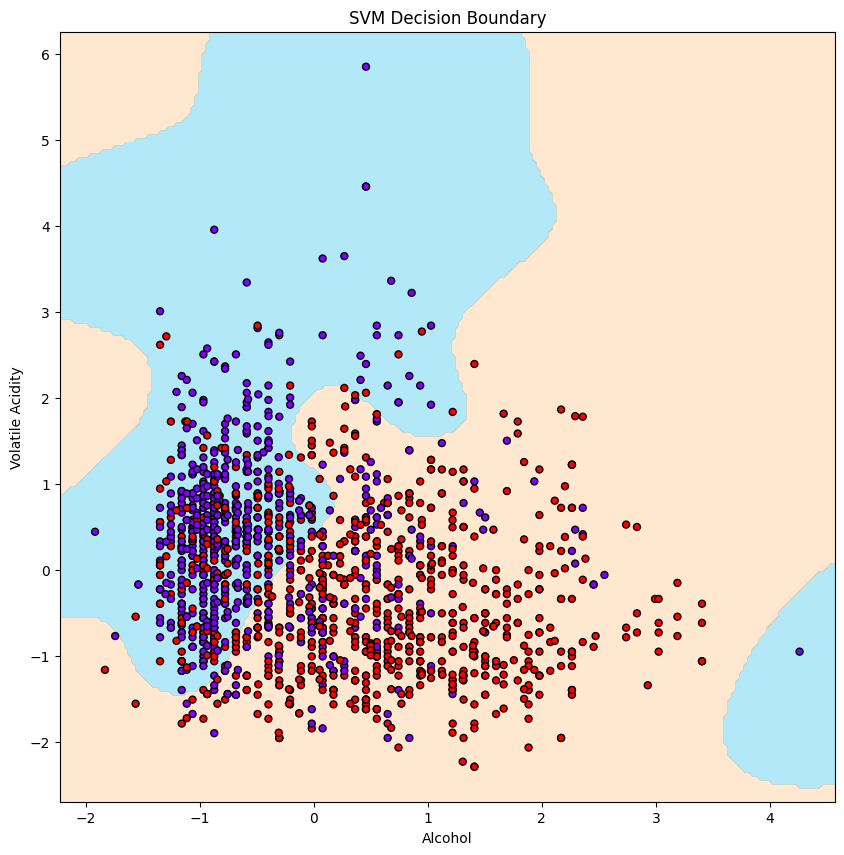

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Title and axis labels
title = 'SVM Decision Boundary'
xlabel = 'Alcohol'
ylabel = 'Volatile Acidity'

plt.rcParams['figure.figsize'] = (10, 10)

def visualize_boundary(model, X, y, title, xlabel, ylabel):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k', zorder=3)
    ax.axis('tight')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap='rainbow',zorder=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

visualize_boundary(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]), title, xlabel, ylabel)
